In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_csv("cleaned_data.csv")

In [3]:
# Selecting and encoding features
features = df[['average_rating', 'rating_number', 'brand', 'main_category']].copy()

# Encoding categorical features 
features['brand_encoded'] = LabelEncoder().fit_transform(features['brand'].astype(str))
features['cat_encoded'] = LabelEncoder().fit_transform(features['main_category'].astype(str))


X = features[['average_rating', 'rating_number', 'brand_encoded', 'cat_encoded']]

In [5]:
# Scale features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Applying KMeans clustering 
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
features['cluster'] = kmeans.fit_predict(X_scaled)

# Cluster summary
cluster_summary = features.groupby('cluster').agg(
    avg_rating=('average_rating', 'mean'),
    avg_reviews=('rating_number', 'mean'),
    avg_brand_id=('brand_encoded', 'mean'),
    avg_cat_id=('cat_encoded', 'mean'),
    count=('cluster', 'count')
)

print("\nCluster Summary:")
print(cluster_summary)



Cluster Summary:
         avg_rating  avg_reviews  avg_brand_id  avg_cat_id   count
cluster                                                           
0          4.256334   418.871261   6807.059795    0.000000  164262
1          3.003653   109.056489   9574.706100    0.000081   49408
2          3.655996   160.580675  21805.126310    0.000000  119919
3          4.519109  8864.559076  16141.353412    0.000673   13381
4          4.473401   609.731401  21443.759790    0.040228  125436


In [6]:
# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
features['pca1'] = X_pca[:, 0]
features['pca2'] = X_pca[:, 1]

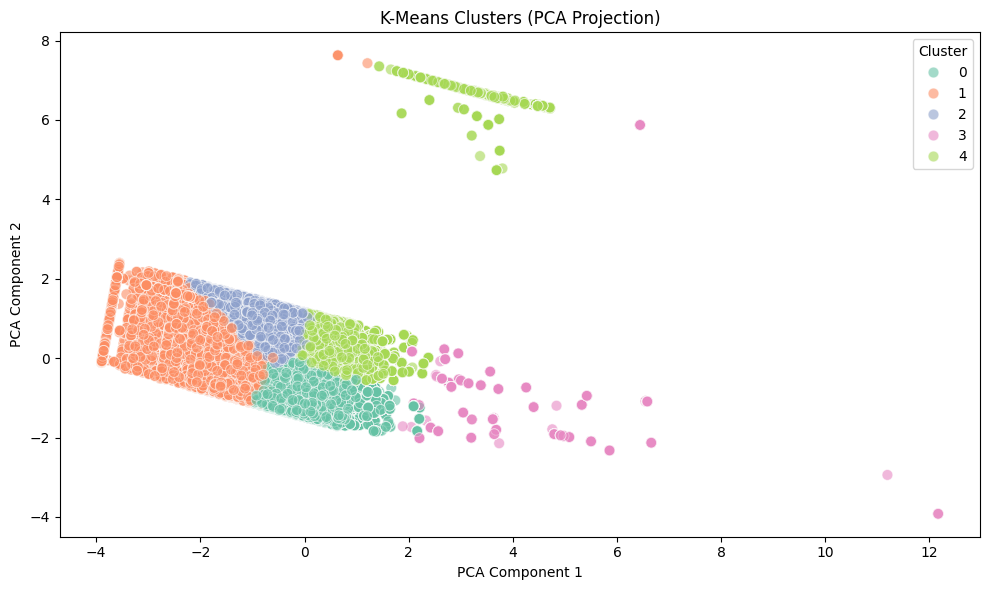

In [7]:
# Visualizing cluster counts with PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features, x='pca1', y='pca2', hue='cluster', palette='Set2', alpha=0.6, s=60)
plt.title("K-Means Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

Applied K-Means clustering (k = 5) to segment products based on average rating, number of reviews, brand, and category. Each product was encoded using label encoding for brand and category and scaled using standard normalization.

**Cluster Interpretations:**
- **Cluster 0**: Comprises products with high ratings and a moderate number of reviews. Average brand and category IDs suggest mid-range popularity and niche domains.
- **Cluster 1**: Characterized by low average ratings and lower review counts. Often includes lesser-known brands or unpopular categories.
- **Cluster 2**: Features high review counts and above-average ratings, typically from well-known brands in dominant product categories.
- **Cluster 3**: Small cluster with mixed ratings but very low review numbers, possibly new or niche items.
- **Cluster 4**: Balanced average rating and review volume, representing a general consumer sentiment category.

The PCA plot shows distinct cluster separation, validating our segmentation approach.